In [1]:
import os
from timeit import default_timer as timer
import pandas as pd
from datetime import datetime, timedelta
from glob import glob
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
path_to_data='/scratch/spf248/covid/data'
start_date='01/01/2020'
end_date='04/16/2020'
source='cuebiq'
country='ID'

In [3]:
def clean_dates(df,start_date=start_date,end_date=end_date):
    currentYear = datetime.now().year
    df['keep_date']=df.date.apply(lambda x:int(x.split('-')[0])==currentYear)
    df=df[df.keep_date==True].copy()
    df.drop('keep_date',1,inplace=True)
    df.date=pd.to_datetime(df.date)
    df=df[(df['date']>=pd.to_datetime(start_date))&(df['date']<=pd.to_datetime(end_date))].copy()
    return df

# Users Activity Over Time

In [4]:
print('Import')
start = timer()
data_dir = Path(os.path.join(path_to_data,source,'processed',country,'n_pings_id_date_hour'))
n_pings_id_date_hour = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import
Done in 59 sec


In [5]:
print('Process')
start = timer()
n_pings_id_date_hour=clean_dates(n_pings_id_date_hour)
print("Done in", round(timer()-start), "sec")

Process
Done in 49 sec


In [6]:
print('Group')
start = timer()
n_pings_id_date_hour=clean_dates(n_pings_id_date_hour)
n_pings_users_date=n_pings_id_date_hour.groupby('date').agg({'cuebiq_id':'nunique','n_pings':'sum'})
print("Done in", round(timer()-start), "sec")

Group
Done in 223 sec


Figure


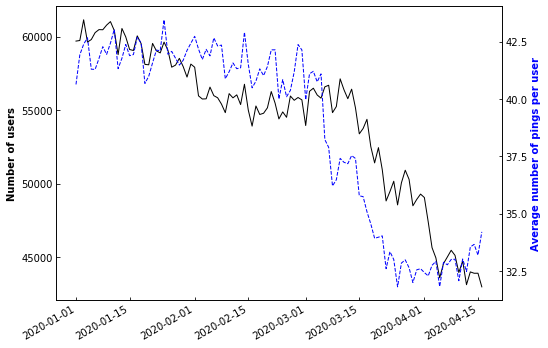

In [11]:
print('Figure')

fig,ax1=plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()

data1=n_pings_users_date['cuebiq_id'].truncate(after=end_date)
ax1.plot(data1.index,data1.values,linewidth=1,color='black')
data2=n_pings_users_date['n_pings'].divide(n_pings_users_date['cuebiq_id']).truncate(after=end_date)
ax2.plot(data2.index,data2.values,linewidth=1,color='b',linestyle='dashed')

ax1.tick_params(which='both',direction='in',pad=3)
ax2.tick_params(which='both',direction='in',pad=3)
ax1.locator_params(axis='y',nbins=6)
ax2.locator_params(axis='y',nbins=6)

ax1.set_xlabel('')
ax1.set_ylabel('Number of users',fontweight='bold',color='black')
ax2.set_ylabel('Average number of pings per user',fontweight='bold',color='b')
fig.autofmt_xdate()

plt.savefig(os.path.join(path_to_data+'/../fig',country,'activity-per-day.png'),bbox_inches='tight')